#TUIA - Aprendizaje Automático 1

##Trabajo práctico N°2: Predicción de lluvia en Australia

Integrantes:
- Moresco, Brisa
- Brizuela Cipolletti, Sofía

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from time import sleep

# Creación de clusters
Se solicita en primera instancia crear clusters con las ciudades del Dataset para catalogarlas en otra categoría: regiones. La cantidad de regiones será definida por cada grupo, observarlas en un gráfico de latitud y longitud para acompañar la decisión.

In [2]:
#https://drive.google.com/file/d/1Sii6XCuwZ_Qvkb9DBk_6OV59H2wPHilQ/view?usp=drive_link
!gdown 1Sii6XCuwZ_Qvkb9DBk_6OV59H2wPHilQ

Downloading...
From: https://drive.google.com/uc?id=1Sii6XCuwZ_Qvkb9DBk_6OV59H2wPHilQ
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 152MB/s]


In [3]:
# Carga del dataset
df = pd.read_csv("/content/weatherAUS.csv")

In [4]:
# Visualización del dataset
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [6]:
df.Location.nunique()

49

In [7]:
def separar_nombre_ciudad(location):
    """Función para insertar espacio en el nombre de una ciudad"""
    return re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', location)

In [8]:
unique_locations = df["Location"].unique() # Obtenemos las ciudades únicas
ciudades_formateadas = [separar_nombre_ciudad(c) for c in unique_locations] # Aplicamos al array de ciudades únicas

# Usamos 'ciudades_formateadas' en la búsqueda con geopy, pero asociando cada coordenada al nombre original
city_mapping = dict(zip(unique_locations, ciudades_formateadas))

geolocator = Nominatim(user_agent="weatherAUS") # Instanciamos el geolocalizador

location_coords = [] # Lista para guardar resultados

# Obtenemos coordenadas para cada ciudad
for nombre_original, nombre_formateado in city_mapping.items():
    try:
        location = geolocator.geocode(f"{nombre_formateado}, Australia")
        if location:
            location_coords.append((nombre_original, location.latitude, location.longitude))
            print(f"{nombre_original} → {nombre_formateado}: {location.latitude}, {location.longitude}")
        else:
            location_coords.append((nombre_original, None, None))
            print(f"{nombre_original}: No encontrado")
    except Exception as e:
        location_coords.append((nombre_original, None, None))
        print(f"{nombre_original}: Error - {e}")
    sleep(1)

coords_df = pd.DataFrame(location_coords, columns=["Location", "Latitude", "Longitude"]) # Convertimos a df

df = df.merge(coords_df, on="Location", how="left") # Merge con el dataset original

Albury → Albury: -36.0737734, 146.9135265
BadgerysCreek → Badgerys Creek: -33.8831452, 150.742466
Cobar → Cobar: -31.9666628, 145.3045054
CoffsHarbour → Coffs Harbour: -30.2985996, 153.1094116
Moree → Moree: -29.4617202, 149.8407153
Newcastle → Newcastle: -32.9192953, 151.7795348
NorahHead → Norah Head: -33.2816667, 151.5677778
NorfolkIsland → Norfolk Island: -29.0328038, 167.9483137
Penrith → Penrith: -33.7511954, 150.6941711
Richmond → Richmond: -37.80745, 144.9907213
Sydney → Sydney: -33.8698439, 151.2082848


SydneyAirport → Sydney Airport: -33.9498935, 151.1819682
WaggaWagga → Wagga Wagga: -35.115, 147.3677778
Williamtown → Williamtown: -32.815, 151.8427778
Wollongong → Wollongong: -34.4243941, 150.89385
Canberra → Canberra: -35.2975906, 149.1012676
Tuggeranong → Tuggeranong: -35.4209771, 149.0921341
MountGinini → Mount Ginini: -35.5297437, 148.7725396
Ballarat → Ballarat: -37.5623013, 143.8605645
Bendigo → Bendigo: -36.7590183, 144.2826718
Sale → Sale: -38.1094463, 147.0656717
MelbourneAirport → Melbourne Airport: -37.6667554, 144.8288501
Melbourne → Melbourne: -37.8142454, 144.9631732
Mildura → Mildura: -34.195274, 142.1503146
Nhil → Nhil: -35.4325403, 141.2833862
Portland → Portland: -38.3456231, 141.6042304


Watsonia → Watsonia: -37.7109468, 145.0837808
Dartmoor → Dartmoor: -37.895212, 141.2679429
Brisbane → Brisbane: -27.4689623, 153.0235009
Cairns → Cairns: -16.9206657, 145.7721854
GoldCoast → Gold Coast: -28.0023731, 153.4145987
Townsville → Townsville: -19.2569391, 146.8239537
Adelaide → Adelaide: -34.9281805, 138.5999312
MountGambier → Mount Gambier: -37.8301386, 140.7842627
Nuriootpa → Nuriootpa: -34.4693354, 138.9939006
Woomera → Woomera: -31.1999142, 136.8253532


Albany → Albany: -35.0247822, 117.883608
Witchcliffe → Witchcliffe: -34.0263348, 115.1004768
PearceRAAF → Pearce RAAF: -31.6739604, 116.0175435
PerthAirport → Perth Airport: -31.9415213, 115.9655769
Perth → Perth: -31.9558933, 115.8605855
SalmonGums → Salmon Gums: -32.9815167, 121.6440785
Walpole → Walpole: -34.9776796, 116.7310063
Hobart → Hobart: -42.8825088, 147.3281233
Launceston → Launceston: -41.4340813, 147.1373496
AliceSprings → Alice Springs: -23.6983884, 133.8812885
Darwin → Darwin: -12.46044, 130.8410469
Katherine → Katherine: -14.4646157, 132.2635993
Uluru → Uluru: -25.3455545, 131.0369615


In [9]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitude,Longitude
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,-36.073773,146.913526
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,-36.073773,146.913526
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,-36.073773,146.913526
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,-36.073773,146.913526
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,-36.073773,146.913526


Cluster con K-Means

In [10]:
# Obtenemos coordenadas únicas por ciudad
city_coords = df[['Location', 'Latitude', 'Longitude']].drop_duplicates().dropna(subset=['Latitude', 'Longitude'])

# Creamos matriz de coordenadas para clustering
matriz_X = city_coords[['Latitude', 'Longitude']].values

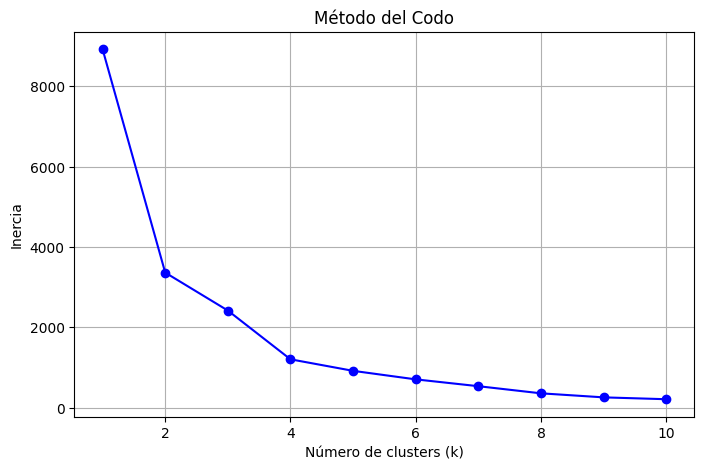

In [11]:
# Implementamos el método del codo

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(matriz_X)
    inertia.append(kmeans.inertia_)

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

A partir del gráfico podemos observar que el “codo” (el punto donde la curva se empieza a aplanar) sucede cuando k=4

In [12]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
city_coords['Region'] = kmeans.fit_predict(city_coords[['Latitude', 'Longitude']].values)

# Unimos al dataset original
df = df.merge(city_coords[['Location', 'Region']], on='Location', how='left')

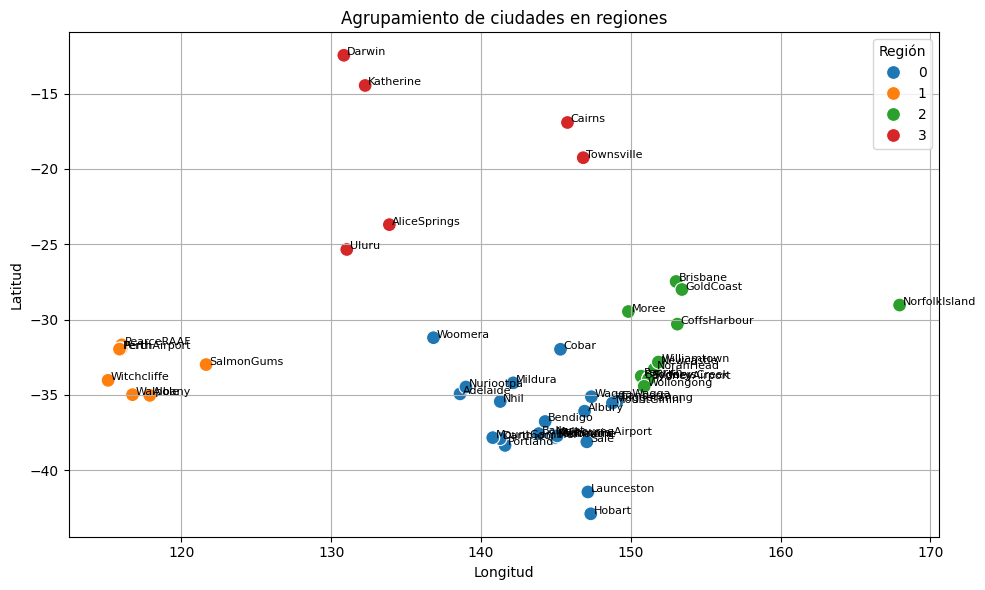

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=city_coords,
    x='Longitude', y='Latitude',
    hue='Region',
    palette='tab10',
    s=100
)

for _, row in city_coords.iterrows():
    plt.text(row['Longitude'] + 0.2, row['Latitude'], row['Location'], fontsize=8)

plt.title('Agrupamiento de ciudades en regiones')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title='Región')
plt.grid(True)
plt.tight_layout()
plt.show()

A partir del gráfico podemos observar que las ciudades se agrupan de manera coherente en función de su ubicación geográfica

# Análisis descriptivo y exploratorio

In [14]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Latitude', 'Longitude',
       'Region'],
      dtype='object')

El dataset cuenta con las siguientes variables:
1. **Date**: Fecha en la que se realizaron las observaciones meteorológicas
2. **Location**: Ciudad donde se realizó la medición del clima
3. **MinTemp**: Temperatura mínima registrada durante el día (grados Celsius)
4. **MaxTemp**: Temperatura máxima registrada durante el día (grados Celsius)
5. **Rainfall**: Cantidad de precipitación registrada para el día (milímetros)
6. **Evaporation**: Cantidad estimada de agua evaporada en el día (milímetros)
7. **Sunshine**: Cantidad de horas de sol durante el día
8. **WindGustDir**: Dirección del viento en el momento de la ráfaga de viento más fuerte del día
9. **WindGustSpeed**: Velocidad del viento en la ráfaga más fuerte del día (km/h)
10. **WindDir9am**: Dirección del viento a las 9am
11. **WindDir3pm**: Dirección del viento a las 3pm
12. **WindSpeed9am**: Velocidad del viento a las 9am (km/h)
13. **WindSpeed3pm**: Velocidad del viento a las 3pm (km/h)
14. **Humidity9am**: Humedad relativa a las 9am (porcentaje %)
15. **Humidity3pm**: Humedad relativa a las 3pm (porcentaje %)
16. **Pressure9am**: Presión atmosférica las 9am (hectopascales hPa)
17. **Pressure3pm**: Presión atmosférica a las 3pm (hectopascales hPa)
18. **Cloud9am**: Cobertura nubosa a las 9am (octavos)
19. **Cloud3pm**: Cobertura nubosa a las 3pm (octavos)
20. **Temp9am**: Temperatura a las 9am (grados Celsius)
21. **Temp3pm**: Temperatura registrada a las 3pm (grados Celsius)
22. **RainToday**: Variable categórica binaria (Sí/No) que indica si llovió en el día actual
23. **RainTomorrow**: Variable categórica binaria (Sí/No) que indica si lloverá al día siguiente
24. **Latitude**: Latitud geográfica de la ciudad donde se realizó la observación
25. **Longitude**: Longitud geográfica de la ciudad donde se realizó la observación
26. **Region**: Región geográfica asignada a la ciudad según agrupamiento por coordenadas (clusters mediante K-Means)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [16]:
# Verificamos valores faltantes
df.isnull().sum()

,0
Date,0
Location,0
MinTemp,1485
MaxTemp,1261
Rainfall,3261
Evaporation,62790
Sunshine,69835
WindGustDir,10326
WindGustSpeed,10263
WindDir9am,10566


In [17]:
# Resumen descriptivo de las variables
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Latitude,Longitude,Region
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,145460.000000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,-32.861469,141.960054,1.011825
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,6.035275,12.034142,1.082912
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,-42.882509,115.100477,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,-36.759018,138.599931,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,-34.026335,145.304505,1.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,-31.673960,150.694171,2.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000,-12.460440,167.948314,3.000000


El dataset cuenta con 23 columnas y un total de 145460 registros, siendo la mayoría de las variables de tipo object (variables categóricas) o float64 (variables númericas).

Casi todas las variables tienen valores faltantes, en donde la mayor cantidad se concentra en Sunshine (cantidad de horas de luz solar), Evaporation (evaporación), Cloud9am y Cloud3am (cobertura nubosa).

Las únicas columnas con valores negativos son MinTemp, MaxTemp, Temp9am y Temp3pm. Esto es correcto ya que la temperatura puede ser negativa a diferencia de las demás variables.

Decidimos eliminar las filas donde la variable target ('RainTomorrow') sea nula

In [18]:
df = df.dropna(subset=['RainTomorrow'])

In [19]:
# Eliminamos las filas donde haya más de 10 variables con valores faltantes
df = df.dropna(thresh=df.shape[1] - 10)

In [20]:
# Convertimos la variable Date a tipo date
df['Date'] = pd.to_datetime(df['Date'])

In [21]:
# Obtener dummies para las columnas RainToday y RainTomorrow
df = pd.get_dummies(df, columns=['RainToday', 'RainTomorrow'], drop_first=True)
# Renombrar las columnas
df = df.rename(columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})
# Convertir las columnas RainToday y RainTomorrow a 0 y 1
df['RainToday'] = df['RainToday'].astype(int)
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

In [22]:
print("=== Estadísticas descriptivas (categóricas) ===")
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColumna: {col}")
    print(f"- Valores únicos: {df[col].nunique()}")
    print(f"- Frecuencias:\n{df[col].value_counts().head(5)}")
    print(f"- Valores nulos: {df[col].isnull().sum()}")

=== Estadísticas descriptivas (categóricas) ===

Columna: Location
- Valores únicos: 49
- Frecuencias:
Location
Sydney      3337
Canberra    3206
Perth       3193
Darwin      3192
Hobart      3188
Name: count, dtype: int64
- Valores nulos: 0

Columna: WindGustDir
- Valores únicos: 16
- Frecuencias:
WindGustDir
W      9754
SE     9301
E      9058
N      9024
SSE    8989
Name: count, dtype: int64
- Valores nulos: 7725

Columna: WindDir9am
- Valores únicos: 16
- Frecuencias:
WindDir9am
N      11360
SE      9068
E       9014
SSE     8964
S       8488
Name: count, dtype: int64
- Valores nulos: 8715

Columna: WindDir3pm
- Valores únicos: 16
- Frecuencias:
WindDir3pm
SE     10633
W       9884
S       9590
WSW     9306
SW      9171
Name: count, dtype: int64
- Valores nulos: 2226


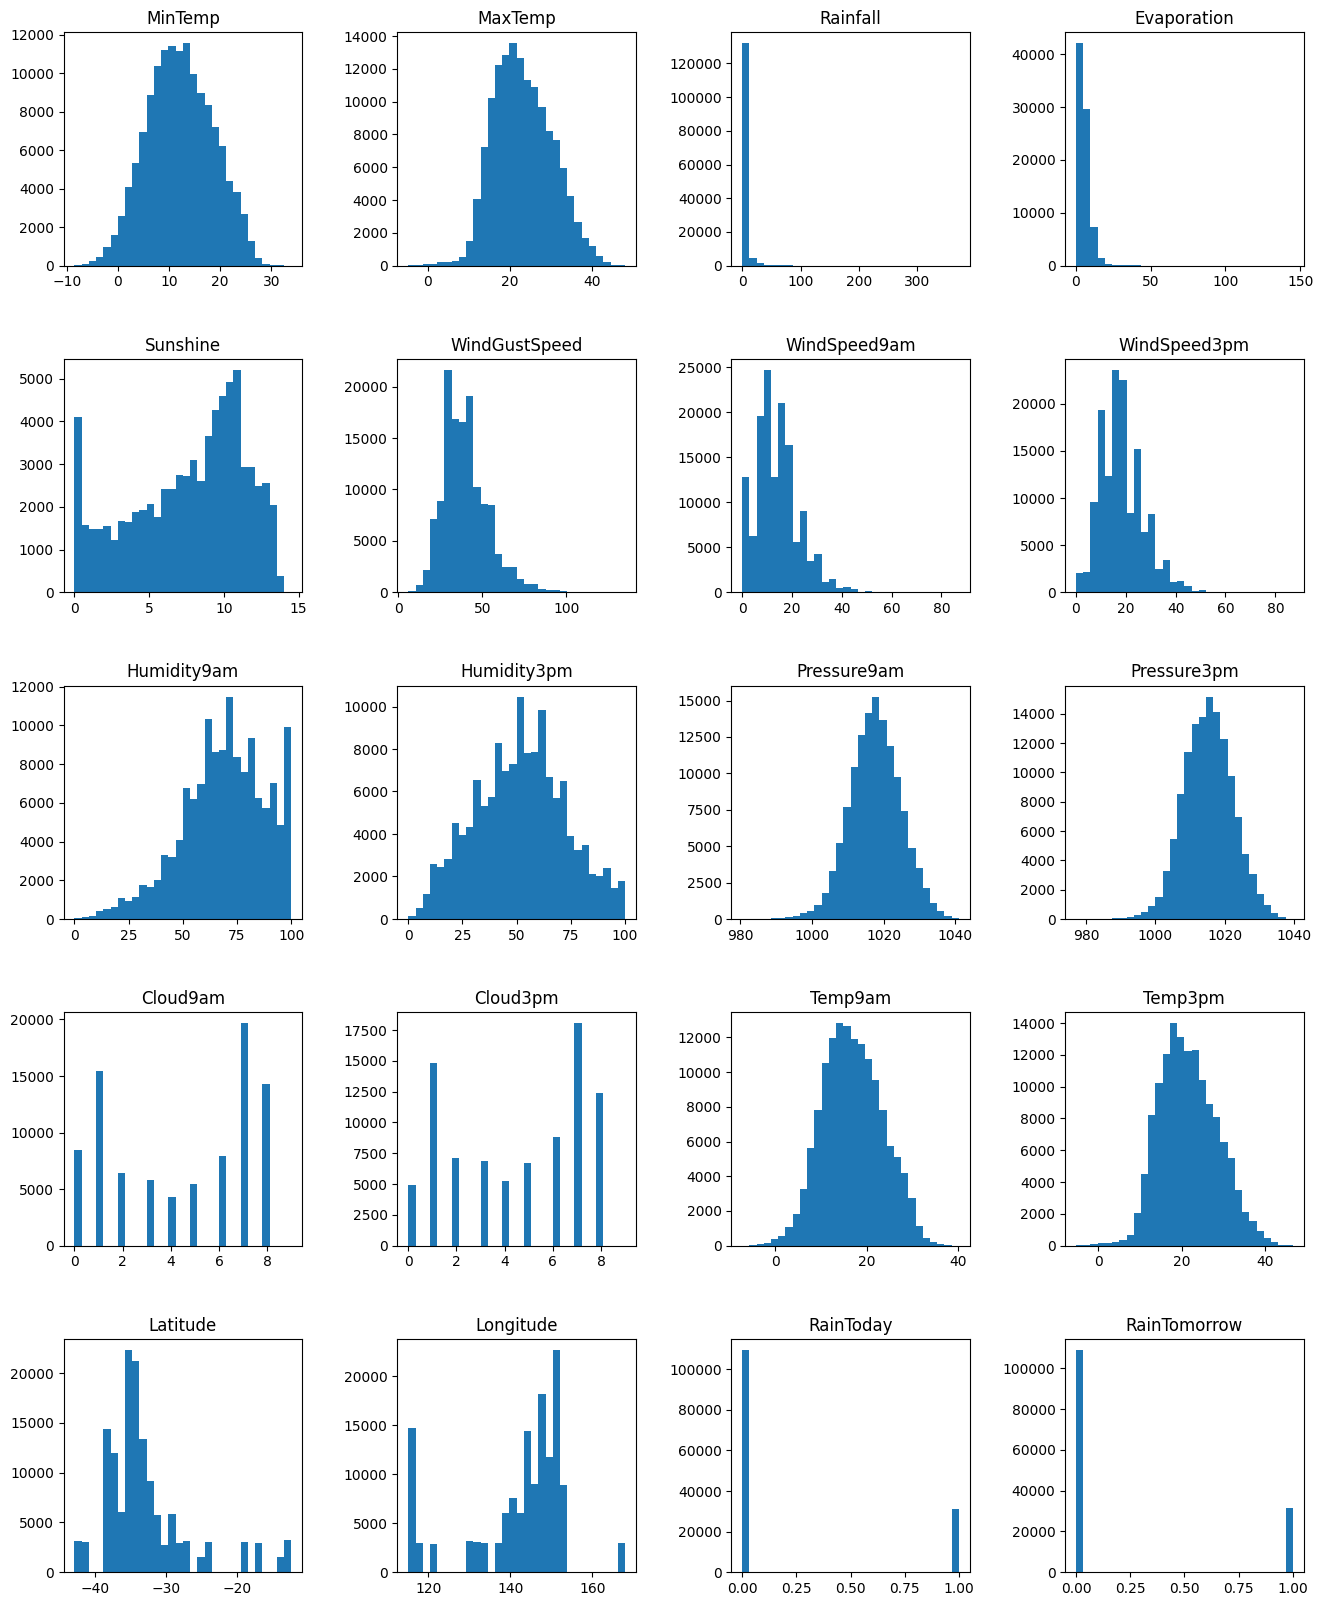

In [23]:
# Filtrar las columnas numéricas del dataset
df_numerico = df.select_dtypes(include=['float64', 'int64'])

# Determinar la cantidad de variables numéricas
num_vars = len(df_numerico.columns)

# Configurar la figura y las subplots
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))

fig.subplots_adjust(hspace=0.4, wspace=0.4) # Ajustar espacio entre los gráficos

# Iterar sobre las columnas y plotear cada una en su propio subplot (histograma)
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    axes[row, col].hist(df_numerico[column], bins=30)
    axes[row, col].set_title(column)

# Eliminar gráficos vacíos en caso de no completar la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

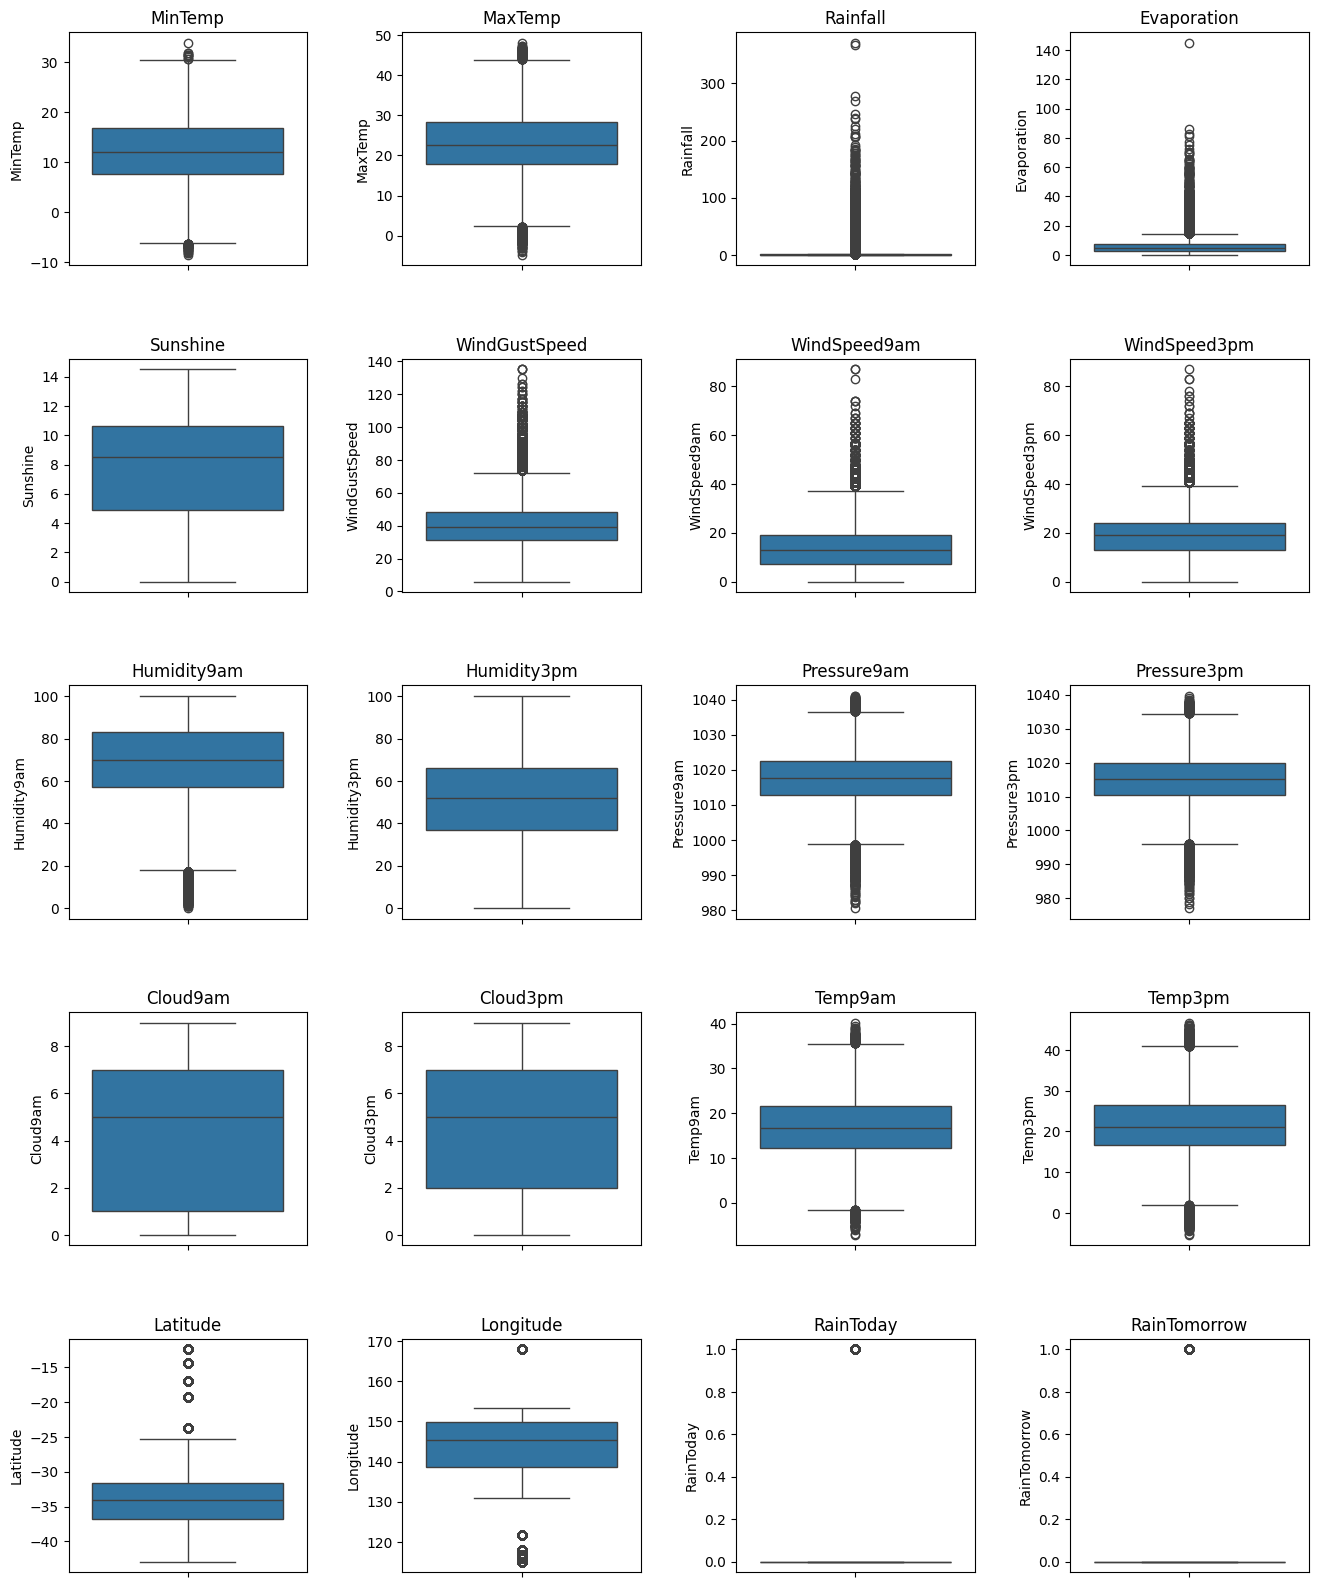

In [24]:
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Recorrer las columnas y plotear cada una en su propio subplot (boxplot)
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    sns.boxplot(data=df_numerico, y=column, ax=axes[row, col])
    axes[row, col].set_title(column)

for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

Al analizar la distribución y los boxplots de las variables numéricas, podemos observar que hay:
- Distribuciones simétricas (normales): hay gráficos de variables que tienen forma de campana, similar a la de distribución normal
- Distribuciones asimétricas (sesgadas): existen variables que muestran sesgo hacia la izquierda o la derecha
- Outliers: la mayoría de las variables presentan valores atípicos, pero hay que considerar que pueden representar eventos meteorológicos reales

In [25]:
temperature_vars = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']
df[temperature_vars].describe()

,MinTemp,MaxTemp,Temp9am,Temp3pm
count,140131.000000,140217.000000,139974.000000,138722.000000
mean,12.189084,23.231610,16.982772,21.695417
std,6.403174,7.116195,6.499842,6.933308
min,-8.500000,-4.800000,-7.200000,-5.400000
25%,7.600000,17.900000,12.300000,16.600000
50%,12.000000,22.600000,16.700000,21.100000
75%,16.800000,28.300000,21.600000,26.400000
max,33.900000,48.100000,40.200000,46.700000


array([[<Axes: title={'center': 'MinTemp'}>,
        <Axes: title={'center': 'MaxTemp'}>],
       [<Axes: title={'center': 'Temp9am'}>,
        <Axes: title={'center': 'Temp3pm'}>]], dtype=object)

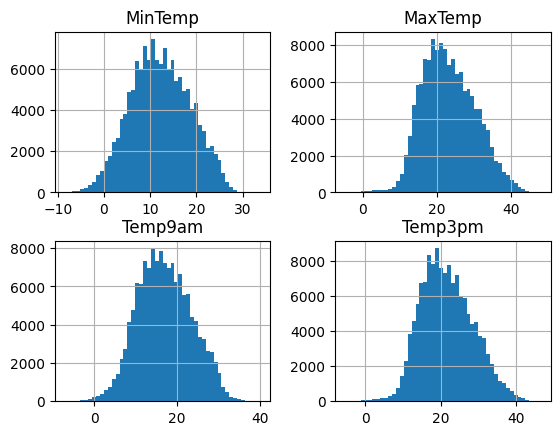

In [26]:
df[temperature_vars].hist(bins=50)

Se observa que las cuatro variables tienen un comportamiento bastante similar y con distribuciones aproximadamente normales

In [27]:
humidity_vars = ['Humidity9am', 'Humidity3pm']
df[humidity_vars].describe()

,Humidity9am,Humidity3pm
count,139128.000000,137852.000000
mean,68.824040,51.475278
std,19.073627,20.792876
min,0.000000,0.000000
25%,57.000000,37.000000
50%,70.000000,52.000000
75%,83.000000,66.000000
max,100.000000,100.000000


array([[<Axes: title={'center': 'Humidity9am'}>,
        <Axes: title={'center': 'Humidity3pm'}>]], dtype=object)

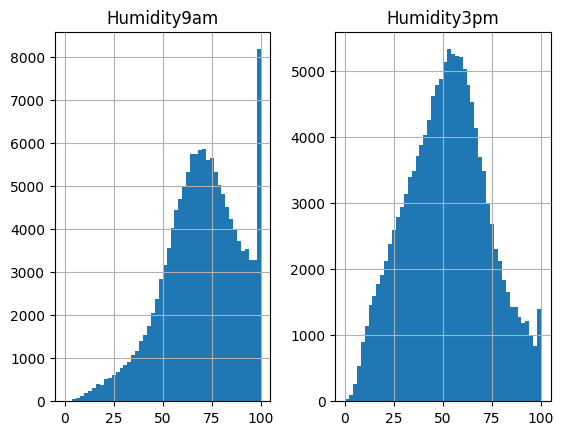

In [28]:
df[humidity_vars].hist(bins=50)

El rango de valores de las variables de humedad está entre 0 y 100, lo cual es lógico ya que la humedad se mide en porcentaje.

**Humidity9am** está claramente sesgada a la izquierda, con un extremo en 100%, indicando que en muchos días la humedad es total a esa hora.

**Humidity3pm** tiene una distribución más parecida a una campana, aunque levemente sesgada hacia la derecha. Muestra que la humedad suele disminuir a la tarde.

In [29]:
preassure_vars = ['Pressure9am', 'Pressure3pm']
df[preassure_vars].describe()

,Pressure9am,Pressure3pm
count,128105.000000,128089.000000
mean,1017.653054,1015.258150
std,7.105174,7.036359
min,980.500000,977.100000
25%,1012.900000,1010.400000
50%,1017.600000,1015.200000
75%,1022.400000,1020.000000
max,1041.000000,1039.600000


array([[<Axes: title={'center': 'Pressure9am'}>,
        <Axes: title={'center': 'Pressure3pm'}>]], dtype=object)

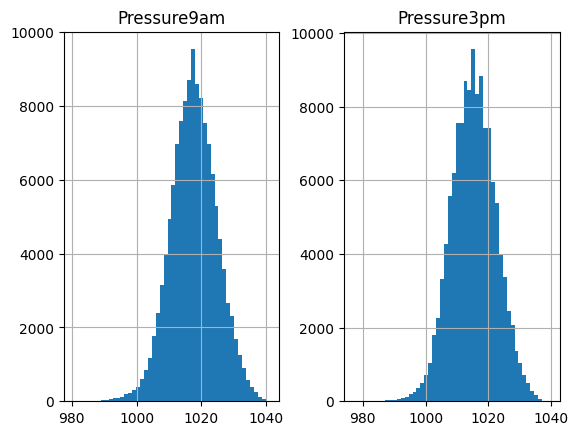

In [30]:
df[preassure_vars].hist(bins=50)

Ambas variables muestran una distribución muy simétrica, semejante a la normal

In [31]:
cloud_vars = ['Cloud9am', 'Cloud3pm']
df[cloud_vars].describe()

,Cloud9am,Cloud3pm
count,87768.000000,85033.000000
mean,4.440081,4.503452
std,2.885344,2.720563
min,0.000000,0.000000
25%,1.000000,2.000000
50%,5.000000,5.000000
75%,7.000000,7.000000
max,9.000000,9.000000


array([[<Axes: title={'center': 'Cloud9am'}>,
        <Axes: title={'center': 'Cloud3pm'}>]], dtype=object)

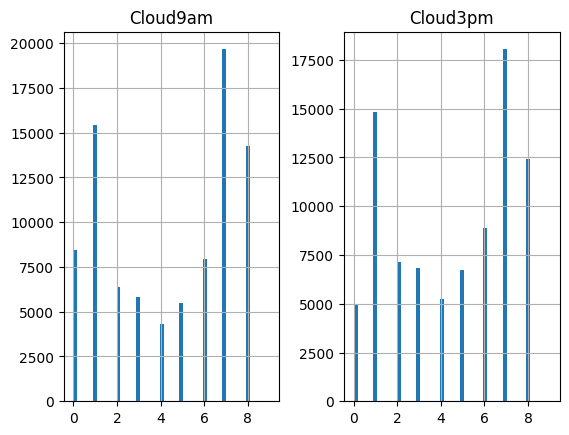

In [32]:
df[cloud_vars].hist(bins=50)

Las variables de nubosidad son variables discretas, cuentan con valores de 0 a 8, donde:

0 = cielo despejado

8 = cielo completamente cubierto de nubes

Se observa que la variable Cloud9am tiene una distribución bimodal, indicando que, en su mayoría, por la mañana, el cielo tiende a estar o despejado o completamente cubierto. Aunque Cloud3pm tiene un comportamiento similar.

###Boxplots de variables numéricas según la región

In [33]:
# Columnas a excluir en los boxplots
columnas_excluidas = ['Latitude', 'Longitude', 'Region', 'RainToday', 'RainTomorrow']

# Columnas a graficar
columnas_a_graficar = [col for col in df_numerico.columns if col not in columnas_excluidas]
num_vars2 = len(columnas_a_graficar)

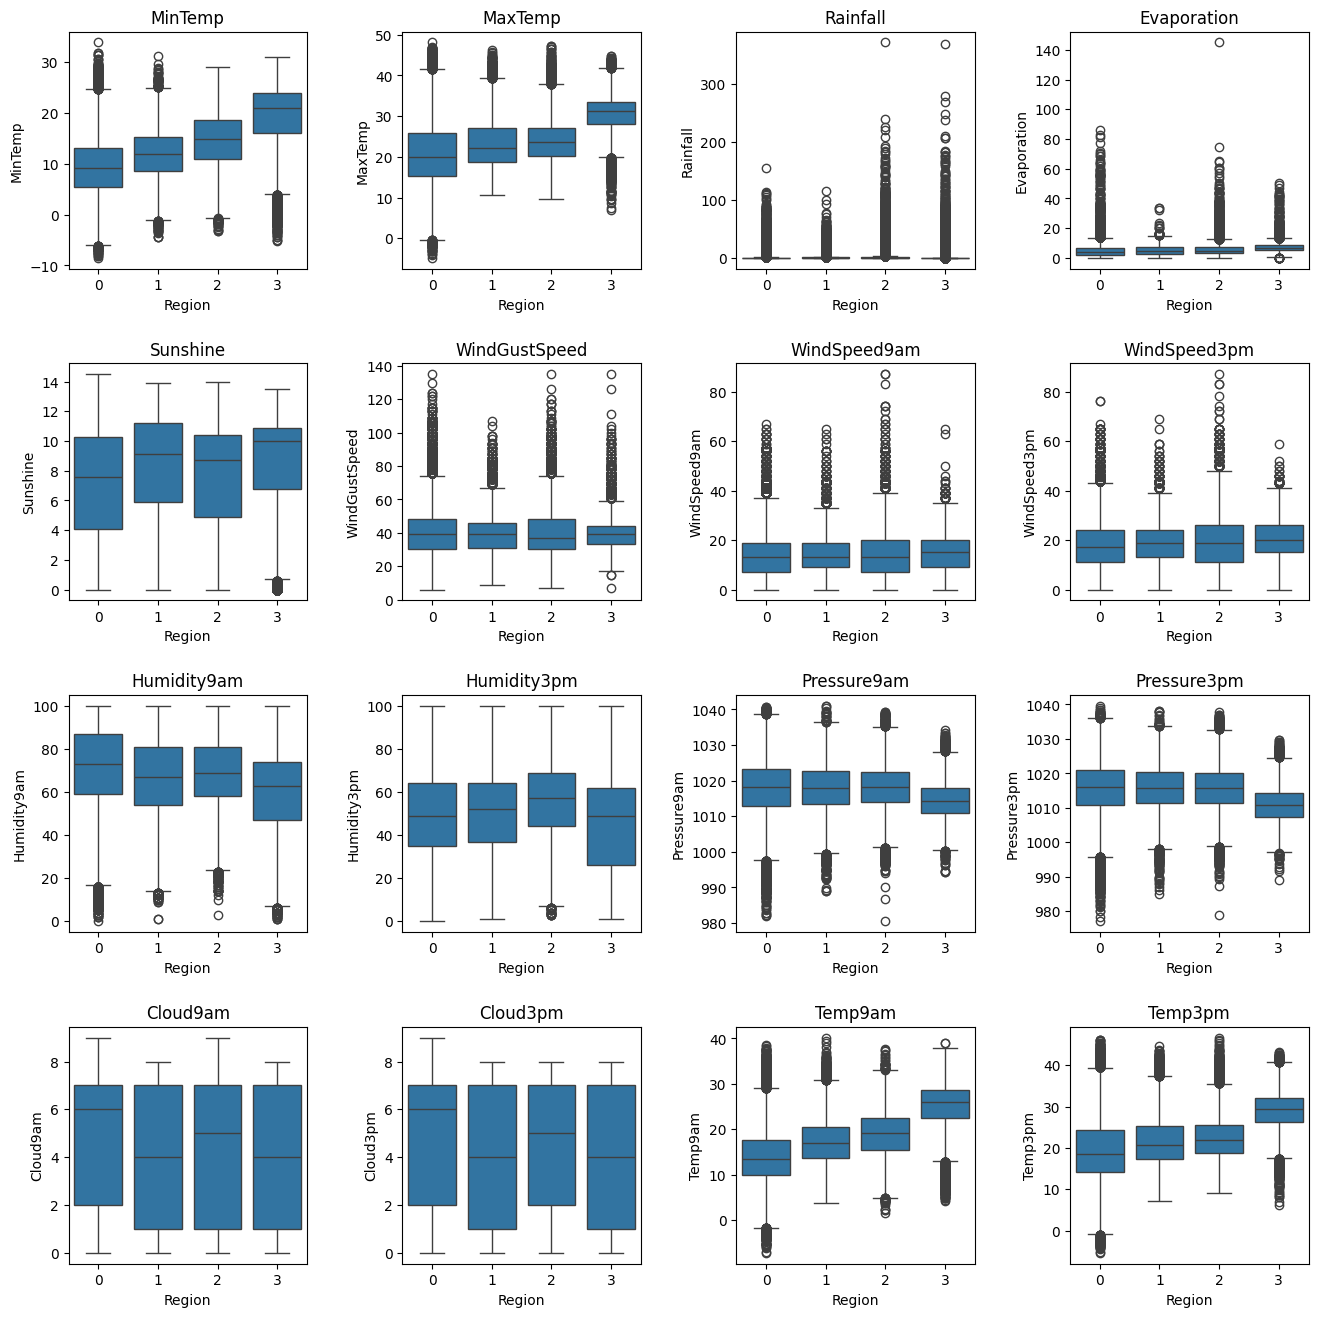

In [34]:
fig, axes = plt.subplots(nrows=(num_vars2 // 4) + (num_vars2 % 4 > 0), ncols=4, figsize=(16, num_vars2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(columnas_a_graficar):
    row, col = divmod(i, 4)
    sns.boxplot(x='Region', data=df, y=column, ax=axes[row, col])
    axes[row, col].set_title(column)

# Eliminar vacíos en caso de no completar la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

A partir de los boxplots de las variables numéricas según la región, podemos analizar que:

- Temperatura (MinTemp, MaxTemp, Temp9am, Temp3pm): La región 0 y 1 parecen tener temperaturas más altas que la región 2, indicando zonas posiblemente más cálidas. Mientras que la región 2 muestra temperaturas más bajas.

- Rainfall: La región 2 muestra mayor variabilidad y valores extremos

- Sunshine: Las regiones 0 y 1 tienen más horas de sol (mayores medianas), mientras que la 2 parece más nublada.

- Wind Variables (WindGustSpeed, WindSpeed9am/3pm): La región 3 muestra velocidades de viento más elevadas.

- Presión (Pressure9am/3pm): Aunque no hay diferencias tan marcadas, la región 1 parece tener presiones atmosféricas ligeramente más altas.

- Cloud9am/Cloud3pm: La región 2 muestra más cobertura nubosa, lo cual coincide con la menor cantidad de sol.

### Boxplots de las variables numéricas en función de la variable target RainTomorrow

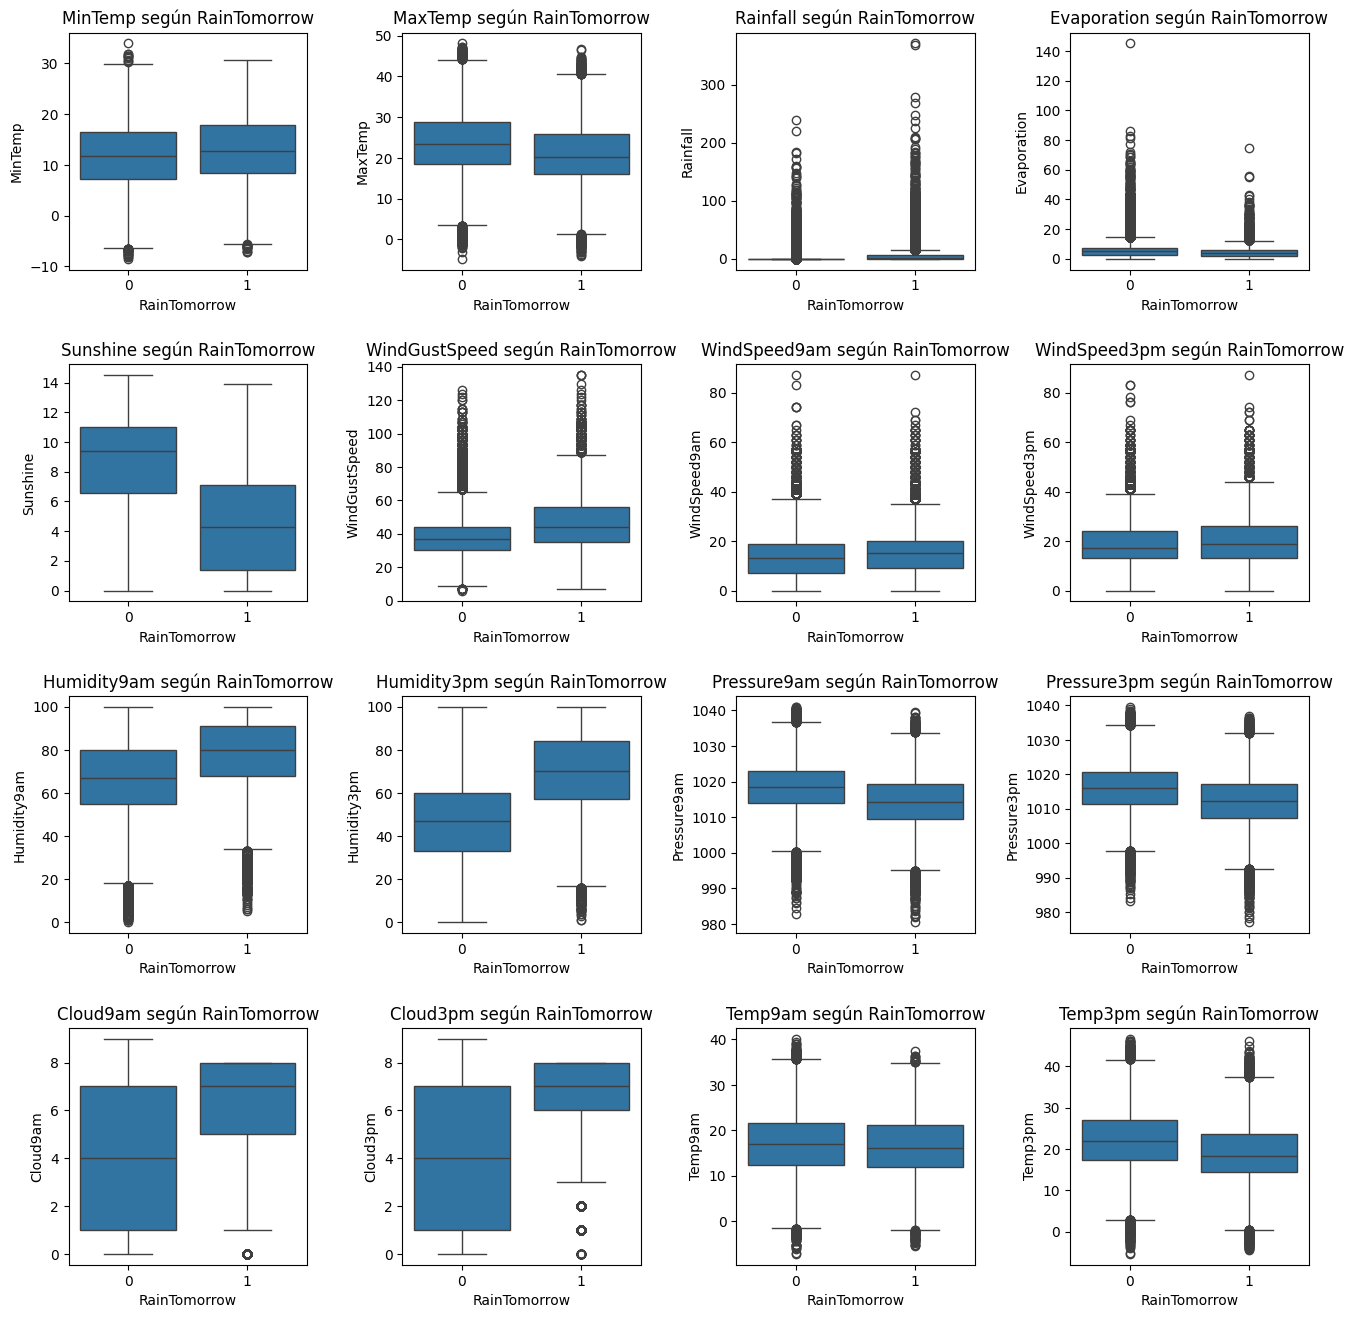

In [35]:
fig, axes = plt.subplots(nrows=(num_vars2 // 4) + (num_vars2 % 4 > 0), ncols=4, figsize=(16, num_vars2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(columnas_a_graficar):
    row, col_idx = divmod(i, 4)
    sns.boxplot(x='RainTomorrow', data=df, y=column, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{column} según RainTomorrow')
    axes[row, col_idx].set_xlabel('RainTomorrow')
    axes[row, col_idx].set_ylabel(column)

for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

A partir del análisis de variables numéricas frente a la variable target, podemos deducir que:

- Temperaturas (MinTemp, MaxTemp, Temp9am, Temp3pm): Generalmente más bajas en días que llueve al día siguiente.

- Rainfall y Evaporation: En el día previo a la lluvia, puede haber habido más precipitación y evaporación.

- Sunshine: La cantidad de luz solar es mucho menor en los días previos a la lluvia. Los días soleados se asocian con menos probabilidad de lluvia.

- Vientos (WindGustSpeed, WindSpeed9am, WindSpeed3pm): Tienden a ser más fuertes cuando hay lluvia el día siguiente.

- Humedad (Humidity9am, Humidity3pm): Es mucho mayor en los días previos a la lluvia. Un alto nivel de humedad es un buen predictor de lluvia.

- Presión atmosférica (Pressure9am y Pressure3pm): Ligeramente más baja antes de días con lluvia.

- Nubosidad (Cloud9am y Cloud3pm): Una mayor nubosidad está asociada a mayor probabilidad de lluvia.

### Distribución de la variable target RainTomorrow

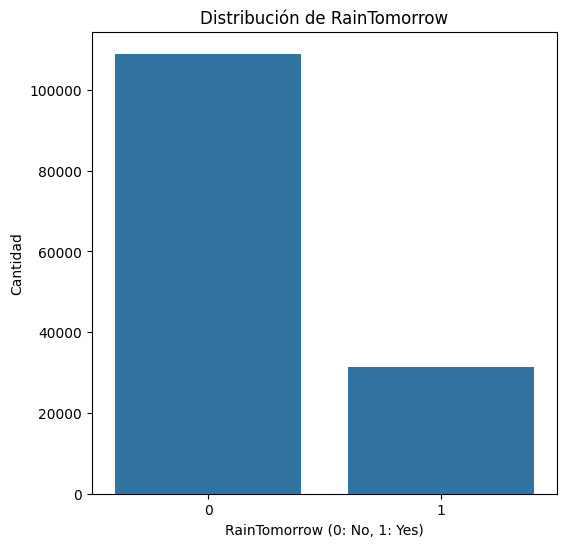

In [36]:
plt.figure(figsize=(6, 6))
sns.countplot(x=df['RainTomorrow'])
plt.title('Distribución de RainTomorrow')
plt.xlabel('RainTomorrow (0: No, 1: Yes)')
plt.ylabel('Cantidad')
plt.show()

Podemos observar que hay un claro desbalanceo de los datos, ya que la cantidad de registros con "No" es mayor a la cantidad de registros con "Yes".

Creemos que se hace esta pregunta para analizar cuestiones que puedan surgir a futuro en nuestro modelo y cómo esto lo afecta.

In [37]:
# Eliminamos las columnas Date y Location ya que no las utilizaremos
df = df.drop(columns=['Date', 'Location'])

# División del conjunto de datos, Train y Test

In [56]:
# Definir las variables predictoras y la variable objetivo
X = df.drop(columns=['RainTomorrow'])  # no usamos la columna objetivo
y = df['RainTomorrow']

# Dividir el conjunto en entrenamiento y prueba (sin imputar)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reporte rápido
print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño prueba:", X_test.shape)
print("Distribución en y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución en y_test:")
print(y_test.value_counts(normalize=True))

Tamaño entrenamiento: (112318, 23)
Tamaño prueba: (28080, 23)
Distribución en y_train:
RainTomorrow
0    0.776082
1    0.223918
Name: proportion, dtype: float64

Distribución en y_test:
RainTomorrow
0    0.776104
1    0.223896
Name: proportion, dtype: float64


# Imputar valores faltantes KNNImputer
- Para las variables numéricas, utilizaremos KNNImputer como ya mencionamos.

- Para las variables categóricas, dado que KNNImputer solo funciona con valores numéricos, utilizaremos otro enfoque para imputar las variables categóricas, como la moda de las variables (la categoría más frecuente en cada columna).

In [39]:
# Identificar las columnas numéricas y categóricas
num_cols = X_train.select_dtypes(include=['float64', 'int']).columns
cat_cols = X_train.select_dtypes(include='object').columns

# Crear el imputador KNN para columnas numéricas
knn_imputer = KNNImputer(n_neighbors=3)

# Imputar las columnas numéricas usando KNNImputer
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

# Imputar las columnas numéricas en X_train usando KNNImputer
X_train_imputed[num_cols] = knn_imputer.fit_transform(X_train_imputed[num_cols])

# Imputar las columnas numéricas en X_test usando el mismo KNNImputer ajustado en X_train
X_test_imputed[num_cols] = knn_imputer.transform(X_test_imputed[num_cols])

# Imputar las columnas categóricas usando la moda (valor más frecuente)
for col in cat_cols:
    # Para X_train, imputamos los valores nulos con la moda
    mode_value_train = X_train[col].mode()[0]  # Moda de la columna en X_train
    X_train_imputed[col] = X_train_imputed[col].fillna(mode_value_train)

    # Para X_test, imputamos los valores nulos con la moda de X_train (no X_test)
    X_test_imputed[col] = X_test_imputed[col].fillna(mode_value_train)

# Verificar si aún hay nulos en los conjuntos imputados
print("\nNulos restantes en X_train_imputed:", X_train_imputed.isnull().sum().sum())
print("Nulos restantes en X_test_imputed:", X_test_imputed.isnull().sum().sum())


Nulos restantes en X_train_imputed: 0
Nulos restantes en X_test_imputed: 0


# One hot enconding (Dummies)

In [40]:
# Agrupaciones simplificadas de direcciones de viento
direccion_viento = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}
mapa_direcciones = {v: k for k, lista in direccion_viento.items() for v in lista}

# Columnas a transformar
columnas_viento = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
columnas_dummies = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

def procesar_X(df):
    df = df.copy()

    # Agrupar direcciones de viento
    for col in columnas_viento:
        df[col] = df[col].map(mapa_direcciones)

    # One-hot encoding
    df = pd.get_dummies(df, columns=columnas_dummies, drop_first=True)

    # Convertir booleanos a 0/1 si los hay
    df.replace({True: 1, False: 0}, inplace=True)

    return df

# Aplicar a X_train y X_test
X_train_processed = procesar_X(X_train_imputed)
X_test_processed = procesar_X(X_test_imputed)

y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

<ipython-input-40-70a82354f913>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)
<ipython-input-40-70a82354f913>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


In [41]:
X_train_processed.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,RainToday,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W
21414,13.9,19.7,0.0,4.600000,10.700000,31.0,13.0,20.0,59.0,55.0,...,0.0,0,1,0,0,0,1,0,1,0
590,6.2,10.0,21.4,2.066667,2.033333,57.0,24.0,19.0,82.0,91.0,...,1.0,1,0,0,1,0,0,1,0,0
79524,8.7,11.9,8.4,1.000000,0.000000,37.0,13.0,15.0,100.0,100.0,...,1.0,0,1,0,0,1,0,0,1,0
104169,10.8,25.2,0.1,4.100000,11.000000,30.0,15.0,11.0,64.0,42.0,...,0.0,0,0,0,1,0,0,0,1,0
5385,2.7,20.1,0.0,4.266667,10.800000,20.0,9.0,4.0,69.0,37.0,...,0.0,0,0,0,0,1,0,1,0,0


In [42]:
X_test_processed

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,RainToday,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W
78429,17.0,32.8,0.0,11.800000,7.800000,39.0,9.0,22.000000,57.0,30.000000,...,0.0,1,0,0,0,0,0,1,0,0
86251,19.1,28.9,56.0,7.000000,10.800000,33.0,7.0,13.000000,64.0,64.000000,...,1.0,1,0,0,1,0,0,1,0,0
70801,18.1,28.7,0.0,9.000000,1.700000,28.0,19.0,11.000000,66.0,39.000000,...,0.0,0,1,0,0,1,0,0,0,0
24206,17.2,22.4,3.8,3.133333,5.300000,33.0,9.0,17.000000,93.0,62.000000,...,1.0,0,1,0,0,1,0,0,1,0
25777,8.3,28.3,0.0,2.466667,9.566667,17.0,2.0,2.000000,92.0,35.000000,...,0.0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145052,7.4,27.8,0.0,4.133333,10.400000,20.0,6.0,7.000000,59.0,16.000000,...,0.0,1,0,0,0,0,0,0,0,0
124834,16.0,24.9,0.0,7.600000,10.400000,74.0,33.0,37.000000,54.0,40.000000,...,0.0,0,0,1,0,0,1,0,0,1
122544,18.4,28.4,0.0,9.400000,10.900000,28.0,9.0,11.000000,59.0,63.000000,...,0.0,0,1,0,1,0,0,0,0,1
31913,18.4,24.8,0.0,5.600000,12.400000,30.0,7.0,19.000000,54.0,54.000000,...,0.0,0,0,0,0,0,0,0,0,0


# Matriz de correlación (numérica)

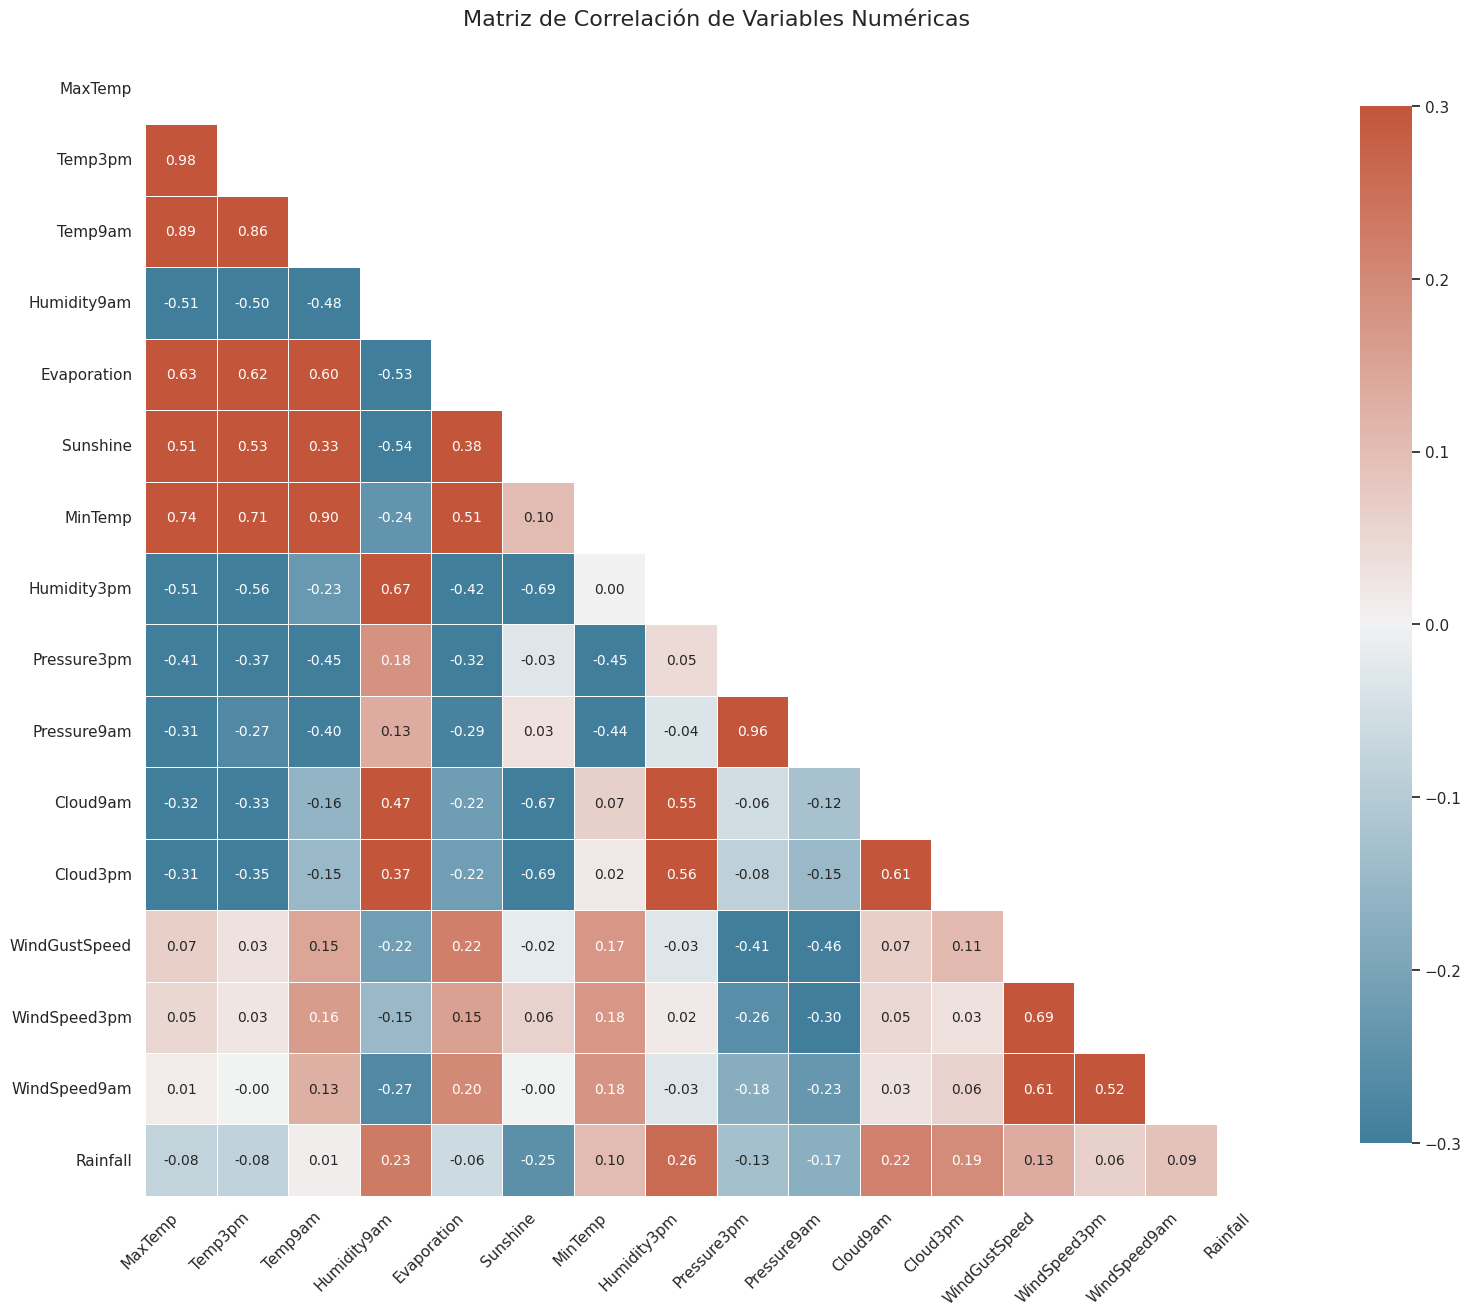

In [43]:
# Definir las columnas numéricas relevantes
numeric_cols = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
    'Temp9am', 'Temp3pm'
]

# Calcular la matriz de correlación
corr_matrix = X_train_processed[numeric_cols].corr()

# Ordenar las variables por su correlación total (opcional, mejora visual)
corr_matrix = corr_matrix.loc[
    corr_matrix.abs().sum().sort_values(ascending=False).index,
    corr_matrix.abs().sum().sort_values(ascending=False).index
]

# Crear la máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Tamaño de la figura
plt.figure(figsize=(16, 14))
sns.set_theme(style="white")

# Paleta de colores personalizada
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap con anotaciones
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmin=-0.3,
    vmax=0.3,
    center=0,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 10}
)

plt.title("Matriz de Correlación de Variables Numéricas", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Matriz de correlación (categórica)

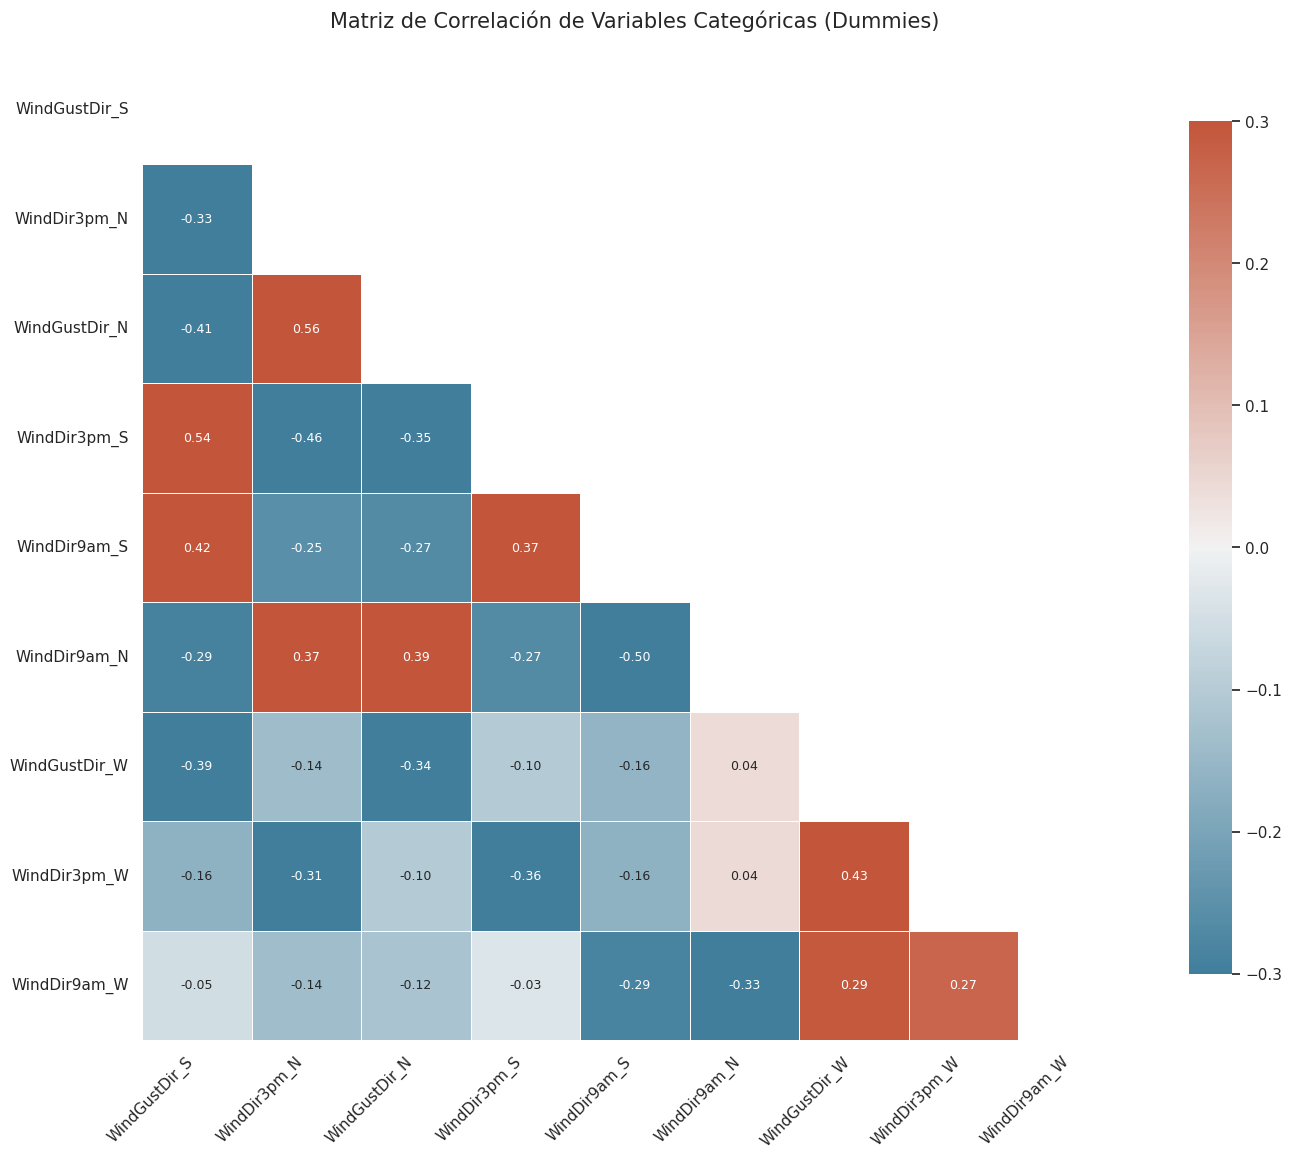

In [44]:
# Establecer estilo
sns.set_theme(style="white")

# Seleccionar variables categóricas dummy
categorical_dummies = [
    'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
    'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W',
    'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W'
]

# Calcular matriz de correlación
corr_matrix = X_train_processed[categorical_dummies].corr()

# Reordenar columnas para visualización clara
corr_matrix = corr_matrix.loc[
    corr_matrix.abs().sum().sort_values(ascending=False).index,
    corr_matrix.abs().sum().sort_values(ascending=False).index
]

# Crear máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Tamaño y figura
plt.figure(figsize=(14, 12))

# Colormap personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmin=-0.3,
    vmax=0.3,
    center=0,
    square=True,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 9}
)

plt.title("Matriz de Correlación de Variables Categóricas (Dummies)", fontsize=15, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Estandarización

Estandarizamos las características porque pueden tener diferentes rangos de valores.
Estandarizarlas asegura que todas las características tengan la misma escala, lo que evita que las características
con mayores rangos dominen el modelo.

In [45]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [46]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
# Aplicar la estandarización a las columnas seleccionadas
X_train_processed[columns_to_standardize] = scaler.fit_transform(X_train_processed[columns_to_standardize])

In [47]:
X_train_processed

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,RainToday,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W
21414,0.268537,-0.493934,-0.283602,-0.160180,0.915889,-0.650470,-0.113713,0.154087,-0.519452,0.165150,...,0.0,0,1,0,0,0,1,0,1,0
590,-0.934434,-1.855970,2.317290,-0.835343,-1.506077,1.274376,1.127775,0.040250,0.686462,1.898627,...,1.0,1,0,0,1,0,0,1,0,0
79524,-0.543859,-1.589180,0.737309,-1.119622,-2.074308,-0.206274,-0.113713,-0.415100,1.630220,2.331997,...,1.0,0,1,0,0,1,0,0,1,0
104169,-0.215776,0.278354,-0.271448,-0.293436,0.999726,-0.724502,0.112012,-0.870449,-0.257297,-0.460828,...,0.0,0,0,0,1,0,0,0,1,0
5385,-1.481239,-0.437768,-0.283602,-0.249017,0.943835,-1.464828,-0.565163,-1.667311,0.004859,-0.701589,...,0.0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33578,0.877833,0.629395,-0.283602,-0.106877,-0.509345,-0.206274,0.112012,1.064787,-0.467021,0.068846,...,0.0,1,0,0,1,0,0,0,0,0
131774,0.346651,-0.086728,-0.283602,0.159635,-0.034267,-0.650470,-0.339438,0.040250,0.529169,0.598519,...,0.0,0,1,0,0,0,0,0,0,0
48137,0.409143,0.882144,0.858846,1.669868,0.897258,-0.724502,-0.790889,-1.098124,0.267014,-0.268220,...,1.0,1,0,0,0,1,0,1,0,0
66528,-0.887565,-1.364514,-0.283602,-0.853110,-0.956477,1.052279,-0.565163,1.292462,0.529169,0.887432,...,0.0,0,1,0,0,1,0,0,1,0


## Estandarización de Test

In [48]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

# Aplicar la estandarización a las columnas seleccionadas
X_test_processed[columns_to_standardize] = scaler.transform(X_test_processed[columns_to_standardize])

In [49]:
X_test_processed

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,RainToday,WindGustDir_N,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W
78429,0.752849,1.345517,-0.283602,1.758705,0.105462,-0.058209,-0.565163,0.381762,-0.624314,-1.038654,...,0.0,1,0,0,0,0,0,1,0,0
86251,1.080932,0.797894,6.522470,0.479449,0.943835,-0.502405,-0.790889,-0.642775,-0.257297,0.598519,...,1.0,1,0,0,1,0,0,1,0,0
70801,0.924702,0.769811,-0.283602,1.012472,-1.599230,-0.872567,0.563462,-0.870449,-0.152435,-0.605285,...,0.0,0,1,0,0,1,0,0,0,0
24206,0.784095,-0.114811,0.178239,-0.551064,-0.593182,-0.502405,-0.565163,-0.187425,1.263203,0.502215,...,1.0,0,1,0,0,1,0,0,1,0
25777,-0.606351,0.713644,-0.283602,-0.728738,0.599170,-1.686925,-1.355201,-1.894986,1.210772,-0.797893,...,0.0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145052,-0.746958,0.643436,-0.283602,-0.284552,0.832052,-1.464828,-0.903751,-1.325799,-0.519452,-1.712784,...,0.0,1,0,0,0,0,0,0,0,0
124834,0.596619,0.236229,-0.283602,0.639356,0.832052,2.532929,2.143537,2.089324,-0.781607,-0.557132,...,0.0,0,0,1,0,0,1,0,0,1
122544,0.971571,0.727686,-0.283602,1.119077,0.971780,-0.872567,-0.565163,-0.870449,-0.519452,0.550367,...,0.0,0,1,0,1,0,0,0,0,1
31913,0.971571,0.222188,-0.283602,0.106332,1.390967,-0.724502,-0.790889,0.040250,-0.781607,0.116998,...,0.0,0,0,0,0,0,0,0,0,0


**En el conjunto de entrenamiento:**
Se aplica fit_transform del StandardScaler para ajustar el escalador a los datos de entrenamiento y transformar esos datos.

**En el conjunto de prueba:**
Se aplica transform del StandardScaler ya ajustado para transformar los datos de prueba usando la misma media y desviación estándar que en el conjunto de entrenamiento.

Esto asegura una transformación consistente y evita la fuga de información.



# Regresión logística

In [58]:
model = LogisticRegression()
model.fit(X_train_processed, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
# Verificamos los coeficientes asignados a cada variable
model.coef_

array([[ 0.01846075,  0.06415261,  0.06649098, -0.04076233, -0.4439844 ,
         0.72382383, -0.11498962, -0.22892886,  0.04833868,  0.89646571,
         0.15283401, -0.47997488,  0.0234704 ,  0.24258401,  0.14046455,
        -0.04204134,  0.0152274 , -0.0095547 , -0.08988682,  0.35697146,
        -0.01341794,  0.06245058,  0.01948892,  0.13746389, -0.09988506,
         0.0436592 ,  0.17679085, -0.09021115, -0.02036489]])

In [60]:
# Predicciones
y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)[:, 1]

In [61]:
# Cálculo de métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Mostrar resultados
print("Métricas del modelo de Regresión Logística:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Métricas del modelo de Regresión Logística:
Accuracy:  0.8473
Precision: 0.7309
Recall:    0.5033
F1 Score:  0.5961


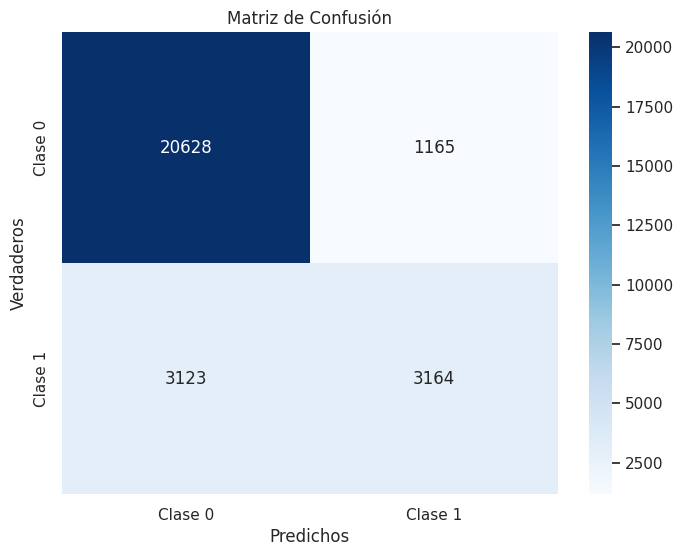

In [62]:
# Matriz de confusión
confusion_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clase 0', 'Clase 1'],
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predichos')
plt.title('Matriz de Confusión')
plt.show()

A partir de la matriz de confusión, podemos observar que el modelo tiende a predecir una mayor cantidad de falsos negativos (3123) que de falsos positivos (1165).

### Cálculo de la curva ROC

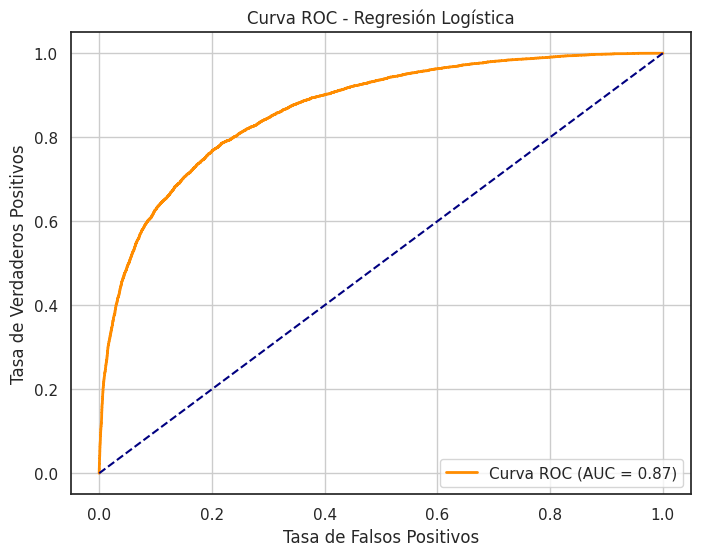

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Por defecto, el modelo de regresión logística utiliza un umbral de 0.5. En este caso, consideramos que ese valor no sería óptimo ya que nuestro dataset está desbalanceado. Para evitar falsos negativos, sería mejor implementar un umbral más bajo.

Para encontrar el mejor umbral, trataremos de maximizar el F1-score para cada umbral.

In [64]:
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"Mejor umbral según F1-score: {best_thresh:.2f} (F1 = {f1_scores[best_idx]:.4f})")

Mejor umbral según F1-score: 0.36 (F1 = 0.6358)


Un umbral de 0.36 mejora el F1-score a 0.6358, lo cual sugiere un mejor equilibrio entre precisión y recall, y prioriza evitar falsos negativos